# Introduction

This notebook will be used only to plot data from the execution of Leaflet Finder with 131K atoms on SuperMic. The experiment setup is as follows:

1. Execution was done on SuperMic.
2. The core count was 64,256,1024 cores
3. 1024 task in total, because of memory issues
4. The calculation was done over 131072,262144 and 524288 atoms.
5. Every task calculates the distances of the atoms it is assigned and returns an edje list. (Memory requirements of the 262K and 524K are 64 and 256GB respectivelly.
6. The produced list was aggregated to a single Unit to calculate the connected components.
7. In case of Spark implementations all three approaches were done

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
import csv
import pandas as pd

blues = cm.get_cmap(plt.get_cmap('Blues'))
greens = cm.get_cmap(plt.get_cmap('Greens'))
reds = cm.get_cmap(plt.get_cmap('Reds'))
oranges = cm.get_cmap(plt.get_cmap('Greens_r'))
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
def CsvToPandas(csvfile):
    csv_data = list()
    for row in csvfile:
        if row[0].startswith('unit.'):
            csv_data.append(float(row[-2]))
    csvdata=np.array(csv_data)
    return csvdata.max()

In [3]:
def SparkLogToDataFrame(path,filename):
    import json
    import pandas
    import numpy as np

    columns=['StageID','TaskId','ExecutorID','LaunchTime','SchedulerDelay','DeserializeTime','Runtime','GettingResultTime','ResultSerializationTime','FinishTime','ResultSize']

    stat_file=open(path+filename)
    stats=list();
    for line in stat_file:
        stats.append(json.loads(line))

      
        
        
    data=pandas.DataFrame(columns=columns,dtype=np.int64)
    data_point = np.zeros((1,11),dtype=np.int64)
    for stat in stats:
        if stat['Event'] == 'SparkListenerTaskEnd':
            data_point[0,0] = int(stat['Stage ID'])
            data_point[0,1] = int(stat['Task Info']['Task ID'])
            data_point[0,2] = int(stat['Task Info']['Executor ID'])
            data_point[0,3] = int(stat['Task Info']['Launch Time'])
            data_point[0,5] = int(stat['Task Metrics']['Executor Deserialize Time'])
            data_point[0,6] = int(stat['Task Metrics']['Executor Run Time'])
            data_point[0,7] = int(stat['Task Info']['Finish Time'])-int(stat['Task Info']['Getting Result Time']) if int(stat['Task Info']['Getting Result Time'])!=0 else 0 
            data_point[0,8] = int(stat['Task Metrics']['Result Serialization Time'])
            data_point[0,9] = int(stat['Task Info']['Finish Time'])
            data_point[0,10] = int(stat['Task Metrics']['Result Size'])
            
            data_point[0,4]= data_point[0,9]-data_point[0,3]-data_point[0,5]-data_point[0,6]-data_point[0,8]-data_point[0,7]
            data_case = pandas.DataFrame(data_point,columns=columns)
            data = data.append(data_case,ignore_index=True)
            
    return data


In [4]:
def SparkSessionToDataFrame(sessionName,path,appName):
    import json
    import pandas
    import numpy as np

    columns=['TaskId','LaunchTime','SchedulerDelay','DeserializeTime','Runtime','ResultSerialization','FinishTime','ResultSize','ReadTime','Exec']
    data=pandas.DataFrame(np.zeros((1,10)),columns=columns,dtype=np.int64)
    data_point = np.zeros((10,1),dtype=np.int64)
    
    if appName != 'miss':
        appPath = path + sessionName + '/' + appName
        print appPath
        timings = np.load(path + sessionName + '/timing.npz.npy')

        stat_file=open(appPath)
        stats=list();
        for line in stat_file:
            stats.append(json.loads(line))

        for stat in stats:
            if stat['Event'] == 'SparkListenerTaskEnd':
                data_point[0] = int(stat['Task Info']['Task ID'])
                data_point[1] = int(stat['Task Info']['Launch Time'])
                data_point[3] = int(stat['Task Metrics']['Executor Deserialize Time'])
                data_point[4] = int(stat['Task Metrics']['Executor Run Time'])
                data_point[5] = int(stat['Task Metrics']['Result Serialization Time'])
                data_point[6] = int(stat['Task Info']['Finish Time'])
                data_point[7] = int(stat['Task Metrics']['Result Size'])
                data_point[2] = data_point[6] - (data_point[1] + data_point[3] \
                                           + data_point[4] + data_point[5])
                data_point[8] = timings[data_point[0],1]-timings[data_point[0],0]
                data_point[9] = timings[data_point[0],2]-timings[data_point[0],1]
                data_case = pandas.DataFrame(data_point.reshape((1,10)),columns=columns)
                data = data.append(data_case,ignore_index=True)
            
    return data

In [5]:
def SessionToPandas(path,sessionName,cores):
    
    unit_path = path+sessionName+'/'
    
    sessionDataFrame = pandas.DataFrame(columns=['Read','Exec','Write'],dtype=np.float)
    for i in range(0,cores):
        data_point = np.zeros((1,3),dtype=np.float)
        stdoutFile = open(unit_path + 'unit.%06i'%i+'/STDOUT')
        for line in stdoutFile:
            if line.startswith('Data Read:'):
                lineList=line.split()
                data_point[0,0] = np.float(lineList[2])
                data_point[0,1] = np.float(lineList[5])
            elif line.startswith('Total Time'):
                lineList = line.split()
                data_point[0,2] = np.float(lineList[6]) - data_point[0,0] - data_point[0,1]
            
        sessionDataFrame = sessionDataFrame.append(pandas.DataFrame((data_point),columns=['Read','Exec','Write']),ignore_index=True)
            
    return sessionDataFrame

## RADICAL-Pilot

In [6]:
RP131_64 = [pd.DataFrame.from_csv('Vanilla/SuperMic/SupRPalO_131Kn_64_1024_%d.csv'%i) for i in range(1,4)]
RP131_256 = [pd.DataFrame.from_csv('Vanilla/SuperMic/SupRPalO_131Kn_256_1024_%d.csv'%i) for i in range(1,4)]
RP131_1024 = [pd.DataFrame.from_csv('Vanilla/SuperMic/SupRPalO_131Kn_1024_1024_%d.csv'%i) for i in range(1,4)]
RP262_64 = [pd.DataFrame.from_csv('Vanilla/SuperMic/SupRPalO_262Kn_64_1024_%d.csv'%i) for i in range(1,4)]
RP262_256 = [pd.DataFrame.from_csv('Vanilla/SuperMic/SupRPalO_262Kn_256_1024_%d.csv'%i) for i in range(1,4)]
RP262_1024 = [pd.DataFrame.from_csv('Vanilla/SuperMic/SupRPalO_262Kn_1024_1024_%d.csv'%i) for i in range(1,4)]
RP524_64 = [pd.DataFrame.from_csv('Vanilla/SuperMic/SupRPalO_524Kn_64_1024_%d.csv'%i) for i in range(1,4)]
RP524_256 = [pd.DataFrame.from_csv('Vanilla/SuperMic/SupRPalO_524Kn_256_1024_%d.csv'%i) for i in range(1,4)]
RP524_1024 = [pd.DataFrame.from_csv('Vanilla/SuperMic/SupRPalO_524Kn_1024_1024_%d.csv'%i) for i in range(1,4)]

RPW131_64 = [pd.DataFrame.from_csv('Vanilla/Wrangler/WraRPalO_131Kn_64_1024_%d.csv'%i) for i in range(1,4)]
RPW131_256 = [pd.DataFrame.from_csv('Vanilla/Wrangler/WraRPalO_131Kn_256_1024_%d.csv'%i) for i in range(1,4)]
RPW262_64 = [pd.DataFrame.from_csv('Vanilla/Wrangler/WraRPalO_262Kn_64_1024_%d.csv'%i) for i in range(1,4)]
RPW262_256 = [pd.DataFrame.from_csv('Vanilla/Wrangler/WraRPalO_262Kn_256_1024_%d.csv'%i) for i in range(1,4)]
RPW524_64 = [pd.DataFrame.from_csv('Vanilla/Wrangler/WraRPalO_524Kn_64_1024_%d.csv'%i) for i in range(1,4)]
RPW524_256 = [pd.DataFrame.from_csv('Vanilla/Wrangler/WraRPalO_524Kn_256_1024_%d.csv'%i) for i in range(1,4)]


In [7]:
RPexpsS = pd.DataFrame(columns=['Atoms','Cores','Run','Overhead','DistExec','DataMovement','ConnComp'])
for i in range(0,3):
    run=i+1
    overhead = RP131_64[i]['Exec'].min()
    dist = RP131_64[i]['StageOut'][:-1].max()-overhead
    data = RP131_64[i]['Exec'][-1]-RP131_64[i]['StageOut'][:-1].max()
    connComp = RP131_64[i]['StageOut'][-1]-RP131_64[i]['Exec'][-1]
    RPexpsS.loc[i]=[131,64,run,overhead,dist,data,connComp]
    overhead = RP131_256[i]['Exec'].min()
    dist = RP131_256[i]['StageOut'][:-1].max()-overhead
    data = RP131_256[i]['Exec'][-1]-RP131_256[i]['StageOut'][:-1].max()
    connComp = RP131_256[i]['StageOut'][-1]-RP131_256[i]['Exec'][-1]
    RPexpsS.loc[i+3]=[131,256,run,overhead,dist,data,connComp]
    overhead = RP131_1024[i]['Exec'].min()
    dist = RP131_1024[i]['StageOut'][:-1].max()-overhead
    data = RP131_1024[i]['Exec'][-1]-RP131_1024[i]['StageOut'][:-1].max()
    connComp = RP131_1024[i]['StageOut'][-1]-RP131_1024[i]['Exec'][-1]
    RPexpsS.loc[i+6]=[131,1024,run,overhead,dist,data,connComp]
    
    overhead = RP262_64[i]['Exec'].min()
    dist = RP262_64[i]['StageOut'][:-1].max()-overhead
    data = RP262_64[i]['Exec'][-1]-RP262_64[i]['StageOut'][:-1].max()
    connComp = RP262_64[i]['StageOut'][-1]-RP262_64[i]['Exec'][-1]
    RPexpsS.loc[i+9]=[262,64,run,overhead,dist,data,connComp]
    overhead = RP262_256[i]['Exec'].min()
    dist = RP262_256[i]['StageOut'][:-1].max()-overhead
    data = RP262_256[i]['Exec'][-1]-RP262_256[i]['StageOut'][:-1].max()
    connComp = RP262_256[i]['StageOut'][-1]-RP262_256[i]['Exec'][-1]
    RPexpsS.loc[i+12]=[262,256,run,overhead,dist,data,connComp]
    overhead = RP262_1024[i]['Exec'].min()
    dist = RP262_1024[i]['StageOut'][:-1].max()-overhead
    data = RP262_1024[i]['Exec'][-1]-RP262_1024[i]['StageOut'][:-1].max()
    connComp = RP262_1024[i]['StageOut'][-1]-RP262_1024[i]['Exec'][-1]
    RPexpsS.loc[i+15]=[262,1024,run,overhead,dist,data,connComp]
    
    overhead = RP524_64[i]['Exec'].min()
    dist = RP524_64[i]['StageOut'][:-1].max()-overhead
    data = RP524_64[i]['Exec'][-1]-RP524_64[i]['StageOut'][:-1].max()
    connComp = RP524_64[i]['StageOut'][-1]-RP524_64[i]['Exec'][-1]
    RPexpsS.loc[i+18]=[524,64,run,overhead,dist,data,connComp]
    overhead = RP524_256[i]['Exec'].min()
    dist = RP524_256[i]['StageOut'][:-1].max()-overhead
    data = RP524_256[i]['Exec'][-1]-RP524_256[i]['StageOut'][:-1].max()
    connComp = RP524_256[i]['StageOut'][-1]-RP524_256[i]['Exec'][-1]
    RPexpsS.loc[i+21]=[524,256,run,overhead,dist,data,connComp]
    overhead = RP524_1024[i]['Exec'].min()
    dist = RP524_1024[i]['StageOut'][:-1].max()-overhead
    data = RP524_1024[i]['Exec'][-1]-RP524_1024[i]['StageOut'][:-1].max()
    connComp = RP524_1024[i]['StageOut'][-1]-RP524_1024[i]['Exec'][-1]
    RPexpsS.loc[i+24]=[524,1024,run,overhead,dist,data,connComp]
    
RPexpsS=RPexpsS.sort_index()


In [8]:
RPexpsW = pd.DataFrame(columns=['Atoms','Cores','Run','Overhead','DistExec','DataMovement','ConnComp'])
for i in range(0,3):
    run=i+1
    overhead = RPW131_64[i]['Executing'].min()
    dist = RPW131_64[i]['AgentStagingOutputPending'][:-1].max()-overhead
    data = RPW131_64[i]['Executing'][-1]-RPW131_64[i]['AgentStagingOutputPending'][:-1].max()
    connComp = RPW131_64[i]['AgentStagingOutputPending'][-1]-RPW131_64[i]['Executing'][-1]
    RPexpsW.loc[i]=[131,64,run,overhead,dist,data,connComp]
    overhead = RPW131_256[i]['Executing'].min()
    dist = RPW131_256[i]['AgentStagingOutputPending'][:-1].max()-overhead
    data = RPW131_256[i]['Executing'][-1]-RPW131_256[i]['AgentStagingOutputPending'][:-1].max()
    connComp = RPW131_256[i]['AgentStagingOutputPending'][-1]-RPW131_256[i]['Executing'][-1]
    RPexpsW.loc[i+3]=[131,256,run,overhead,dist,data,connComp]
    
    overhead = RPW262_64[i]['Executing'].min()
    dist = RPW262_64[i]['AgentStagingOutputPending'][:-1].max()-overhead
    data = RPW262_64[i]['Executing'][-1]-RPW262_64[i]['AgentStagingOutputPending'][:-1].max()
    connComp = RPW262_64[i]['AgentStagingOutputPending'][-1]-RPW262_64[i]['Executing'][-1]
    RPexpsW.loc[i+9]=[262,64,run,overhead,dist,data,connComp]
    overhead = RPW262_256[i]['Executing'].min()
    dist = RPW262_256[i]['AgentStagingOutputPending'][:-1].max()-overhead
    data = RPW262_256[i]['Executing'][-1]-RPW262_256[i]['AgentStagingOutputPending'][:-1].max()
    connComp = RPW262_256[i]['AgentStagingOutputPending'][-1]-RPW262_256[i]['Executing'][-1]
    RPexpsW.loc[i+12]=[262,256,run,overhead,dist,data,connComp]
    
    overhead = RPW524_64[i]['Executing'].min()
    dist = RPW524_64[i]['AgentStagingOutputPending'][:-1].max()-overhead
    data = RPW524_64[i]['Executing'][-1]-RPW524_64[i]['AgentStagingOutputPending'][:-1].max()
    connComp = RPW524_64[i]['AgentStagingOutputPending'][-1]-RPW524_64[i]['Executing'][-1]
    RPexpsW.loc[i+18]=[524,64,run,overhead,dist,data,connComp]
    overhead = RPW524_256[i]['Executing'].min()
    dist = RPW524_256[i]['AgentStagingOutputPending'][:-1].max()-overhead
    data = RPW524_256[i]['Executing'][-1]-RPW524_256[i]['AgentStagingOutputPending'][:-1].max()
    connComp = RPW524_256[i]['AgentStagingOutputPending'][-1]-RPW524_256[i]['Executing'][-1]
    RPexpsW.loc[i+21]=[524,256,run,overhead,dist,data,connComp]
    
RPexpsW=RPexpsW.sort_index()



In [9]:
RPmeansS = pd.DataFrame(columns=['Atoms','Cores','Run','RADICAL-Pilot Overhead','RADICAL-Pilot Edge Disc','RADICAL-Pilot DataMovement','RADICAL-Pilot ConnComp'])
RPmeansS.loc[1] = RPexpsS[0:3].mean().values
RPmeansS.loc[2] = RPexpsS[3:6].mean().values
RPmeansS.loc[3] = RPexpsS[6:9].mean().values
RPmeansS.loc[4] = RPexpsS[9:12].mean().values
RPmeansS.loc[5] = RPexpsS[12:15].mean().values
RPmeansS.loc[6] = RPexpsS[15:18].mean().values
RPmeansS.loc[7] = RPexpsS[18:21].mean().values
RPmeansS.loc[8] = RPexpsS[21:24].mean().values
RPmeansS.loc[9] = RPexpsS[24:27].mean().values
RPmeansS = RPmeansS.drop('Run',1)
RPmeansS = RPmeansS.drop('Atoms',1)
RPmeansS

,Cores,RADICAL-Pilot Overhead,RADICAL-Pilot Edge Disc,RADICAL-Pilot DataMovement,RADICAL-Pilot ConnComp
1,64.0,6.093761,380.849050,7.819341,7.356376
2,256.0,5.487148,380.012419,7.110389,7.562389
3,1024.0,6.213363,378.826127,6.853355,7.458503
4,64.0,5.735915,381.027519,8.461359,12.845671
5,256.0,5.691539,380.890266,6.970701,13.077754
6,1024.0,6.388958,380.840480,7.959969,12.426971
7,64.0,5.783991,930.512528,9.949854,23.170352
8,256.0,6.677023,655.624364,9.026993,22.822334
9,1024.0,5.892168,379.800645,6.656823,22.848890


In [10]:
RPmeansW = pd.DataFrame(columns=['Atoms','Cores','Run','RADICAL-Pilot Overhead','RADICAL-Pilot Edge Disc','RADICAL-Pilot DataMovement','RADICAL-Pilot ConnComp'])
RPmeansW.loc[1] = RPexpsW[0:3].mean().values
RPmeansW.loc[2] = RPexpsW[3:6].mean().values
RPmeansW.loc[3] = RPexpsW[6:9].mean().values
RPmeansW.loc[4] = RPexpsW[9:12].mean().values
RPmeansW.loc[5] = RPexpsW[12:15].mean().values
RPmeansW.loc[6] = RPexpsW[15:18].mean().values
RPmeansW = RPmeansW.drop('Run',1)
RPmeansW = RPmeansW.drop('Atoms',1)
RPmeansW

,Cores,RADICAL-Pilot Overhead,RADICAL-Pilot Edge Disc,RADICAL-Pilot DataMovement,RADICAL-Pilot ConnComp
1,64.0,6.216690,360.697422,7.553453,7.041046
2,256.0,6.346939,362.450343,9.188969,7.103509
3,64.0,6.664690,360.567927,8.916119,11.513877
4,256.0,6.559355,360.958360,8.342719,11.413797
5,64.0,6.338979,363.118834,7.786343,22.591081
6,256.0,6.901499,362.908222,7.251613,22.692835


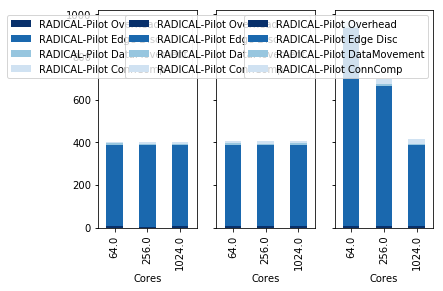

In [11]:
fig,axes=plt.subplots(nrows=1,ncols=3,sharex=True,sharey=True)
RPmeansS[0:3].plot(kind='bar',x='Cores',stacked=True,ax=axes[0],color=[blues(500),blues(200),blues(100),blues(50)])
RPmeansS[3:6].plot(kind='bar',x='Cores',stacked=True,ax=axes[1],color=[blues(500),blues(200),blues(100),blues(50)])
RPmeansS[6:9].plot(kind='bar',x='Cores',stacked=True,ax=axes[2],color=[blues(500),blues(200),blues(100),blues(50)])

# 1. Broadcast Experiments

## 1.1 Setting up everything

In [12]:
spSuperMic = pd.DataFrame.from_csv('Spark/Supermic/SuperMic.csv')

SpSupBroad = spSuperMic[spSuperMic['Style']=='Br']
SpSupCollect = spSuperMic[spSuperMic['Style']=='Col']
SpSupPcc = spSuperMic[spSuperMic['Style']=='Pcc']

SpSupBroad131=SpSupBroad[SpSupBroad['Atom']==131].drop(['SessionName','JsonName','Style','Atom','Run'],1)
SpSupBroad262=SpSupBroad[SpSupBroad['Atom']==262].drop(['SessionName','JsonName','Style','Atom','Run'],1)
SpSupBroad524=SpSupBroad[SpSupBroad['Atom']==524].drop(['SessionName','JsonName','Style','Atom','Run'],1)

SpSupColl131=SpSupCollect[SpSupCollect['Atom']==131].drop(['SessionName','JsonName','Style','Atom','Run'],1)
SpSupColl262=SpSupCollect[SpSupCollect['Atom']==262].drop(['SessionName','JsonName','Style','Atom','Run'],1)
SpSupColl524=SpSupCollect[SpSupCollect['Atom']==524].drop(['SessionName','JsonName','Style','Atom','Run'],1)

SpSupPcc131=SpSupPcc[SpSupPcc['Atom']==131].drop(['SessionName','JsonName','Style','Atom','Run'],1)
SpSupPcc262=SpSupPcc[SpSupPcc['Atom']==262].drop(['SessionName','JsonName','Style','Atom','Run'],1)
SpSupPcc524=SpSupPcc[SpSupPcc['Atom']==524].drop(['SessionName','JsonName','Style','Atom','Run'],1)

SpSupPcc


,Atom,Style,Cores,Run,Overhead,DataInit,AdjList,ConnComp,TotalTime,SessionName,JsonName
18,131.0,Pcc,64.0,1.0,5.361873,0.012084,61.455226,0.004247,61.471557,SupSpPccAlO_131Kn_64_1024_1,app-20170516192320-0000
19,131.0,Pcc,64.0,2.0,5.354072,0.012519,62.379786,0.004100,62.396405,SupSpPccAlO_131Kn_64_1024_2,app-20170516192604-0000
20,131.0,Pcc,64.0,3.0,5.358882,0.012311,63.157183,0.004223,63.173717,SupSpPccAlO_131Kn_64_1024_3,app-20170516192859-0000
21,131.0,Pcc,256.0,1.0,5.364794,0.012464,23.849857,0.004829,23.867150,SupSpPccAlO_131Kn_256_1024_1,app-20170516212925-0000
22,131.0,Pcc,256.0,2.0,5.353332,0.012323,23.976954,0.004758,23.994035,SupSpPccAlO_131Kn_256_1024_2,app-20170516213202-0000
23,131.0,Pcc,256.0,3.0,5.357516,0.011847,161.297647,0.004406,161.313900,SupSpPccAlO_131Kn_256_1024_3,app-20170516213437-0000
24,131.0,Pcc,1024.0,1.0,5.358760,0.011188,161.419254,0.004032,161.434474,SupSpPccAlO_131Kn_1024_1024_1,app-20170516225738-0000
25,131.0,Pcc,1024.0,2.0,5.363421,0.012208,56.300350,0.004402,56.316960,SupSpPccAlO_131Kn_1024_1024_2,app-20170516230550-0000
26,131.0,Pcc,1024.0,3.0,5.359908,0.011265,33.108855,0.004714,33.124834,SupSpPccAlO_131Kn_1024_1024_3,app-20170516231221-0000
45,262.0,Pcc,64.0,1.0,5.356648,0.015990,666.054577,0.004243,666.074810,SupSpPccAlO_262Kn_64_1024_1,app-20170516193153-0000


In [13]:
spWrangler = pd.DataFrame.from_csv('Spark/Wrangler/Wrangler.csv')

SpWraBroad = spWrangler[spWrangler['Style']=='Br']
SpWraCollect = spWrangler[spWrangler['Style']=='Col']
SpWraPcc = spWrangler[spWrangler['Style']=='Pcc']

SpWraBroad131=SpWraBroad[SpWraBroad['Atom']==131].drop(['SessionName','JsonName','Style','Atom','Run'],1)
SpWraBroad262=SpWraBroad[SpWraBroad['Atom']==262].drop(['SessionName','JsonName','Style','Atom','Run'],1)
SpWraBroad524=SpWraBroad[SpWraBroad['Atom']==524].drop(['SessionName','JsonName','Style','Atom','Run'],1)

SpWraColl131=SpWraCollect[SpWraCollect['Atom']==131].drop(['SessionName','JsonName','Style','Atom','Run'],1)
SpWraColl262=SpWraCollect[SpWraCollect['Atom']==262].drop(['SessionName','JsonName','Style','Atom','Run'],1)
SpWraColl524=SpWraCollect[SpWraCollect['Atom']==524].drop(['SessionName','JsonName','Style','Atom','Run'],1)

SpWraPcc131=SpWraPcc[SpWraPcc['Atom']==131].drop(['SessionName','JsonName','Style','Atom','Run'],1)
SpWraPcc262=SpWraPcc[SpWraPcc['Atom']==262].drop(['SessionName','JsonName','Style','Atom','Run'],1)
SpWraPcc524=SpWraPcc[SpWraPcc['Atom']==524].drop(['SessionName','JsonName','Style','Atom','Run'],1)

SpWraPcc262


,Cores,Overhead,DataInit,AdjList,ConnComp,TotalTime
30,64.0,5.436314,0.011446,24.388572,0.008565,24.408583
31,64.0,5.440242,0.010422,24.447450,0.008686,24.466558
32,64.0,5.433806,0.011308,24.507558,0.008433,24.527299
33,256.0,5.433395,0.012081,14.588919,0.008409,14.609409
34,256.0,5.432259,0.012507,14.204250,0.008156,14.224913
35,256.0,5.432759,0.012566,14.084637,0.008385,14.105588


In [14]:
SpSupBroad131['TotalOverhead']=SpSupBroad131['Overhead']+SpSupBroad131['DataInit']
SpSupBroad131 = SpSupBroad131.drop(['Overhead','DataInit'],axis=1)[['Cores','TotalOverhead','AdjList','ConnComp','TotalTime']]

SpSupBroad262['TotalOverhead']=SpSupBroad262['Overhead']+SpSupBroad262['DataInit']
SpSupBroad262 = SpSupBroad262.drop(['Overhead','DataInit'],axis=1)[['Cores','TotalOverhead','AdjList','ConnComp','TotalTime']]

SpSupBroad524['TotalOverhead']=SpSupBroad524['Overhead']+SpSupBroad524['DataInit']
SpSupBroad524 = SpSupBroad524.drop(['Overhead','DataInit'],axis=1)[['Cores','TotalOverhead','AdjList','ConnComp','TotalTime']]

SpSupColl131['TotalOverhead']=SpSupColl131['Overhead']+SpSupColl131['DataInit']
SpSupColl131 = SpSupColl131.drop(['Overhead','DataInit'],axis=1)[['Cores','TotalOverhead','AdjList','ConnComp','TotalTime']]

SpSupColl262['TotalOverhead']=SpSupColl262['Overhead']+SpSupColl262['DataInit']
SpSupColl262 = SpSupColl262.drop(['Overhead','DataInit'],axis=1)[['Cores','TotalOverhead','AdjList','ConnComp','TotalTime']]

SpSupColl524['TotalOverhead']=SpSupColl524['Overhead']+SpSupColl524['DataInit']
SpSupColl524 = SpSupColl524.drop(['Overhead','DataInit'],axis=1)[['Cores','TotalOverhead','AdjList','ConnComp','TotalTime']]

SpSupPcc131['TotalOverhead']=SpSupPcc131['Overhead']+SpSupPcc131['DataInit']
SpSupPcc131 = SpSupPcc131.drop(['Overhead','DataInit'],axis=1)[['Cores','TotalOverhead','AdjList','ConnComp','TotalTime']]

SpSupPcc262['TotalOverhead']=SpSupPcc262['Overhead']+SpSupPcc262['DataInit']
SpSupPcc262 = SpSupPcc262.drop(['Overhead','DataInit'],axis=1)[['Cores','TotalOverhead','AdjList','ConnComp','TotalTime']]

SpSupPcc524['TotalOverhead']=SpSupPcc524['Overhead']+SpSupPcc524['DataInit']
SpSupPcc524 = SpSupPcc524.drop(['Overhead','DataInit'],axis=1)[['Cores','TotalOverhead','AdjList','ConnComp','TotalTime']]

In [15]:
SpWraBroad131['TotalOverhead']=SpWraBroad131['Overhead']+SpWraBroad131['DataInit']
SpWraBroad131 = SpWraBroad131.drop(['Overhead','DataInit'],axis=1)[['Cores','TotalOverhead','AdjList','ConnComp','TotalTime']]

SpWraBroad262['TotalOverhead']=SpWraBroad262['Overhead']+SpWraBroad262['DataInit']
SpWraBroad262 = SpWraBroad262.drop(['Overhead','DataInit'],axis=1)[['Cores','TotalOverhead','AdjList','ConnComp','TotalTime']]

SpWraBroad524['TotalOverhead']=SpWraBroad524['Overhead']+SpWraBroad524['DataInit']
SpWraBroad524 = SpWraBroad524.drop(['Overhead','DataInit'],axis=1)[['Cores','TotalOverhead','AdjList','ConnComp','TotalTime']]

SpWraColl131['TotalOverhead']=SpWraColl131['Overhead']+SpWraColl131['DataInit']
SpWraColl131 = SpWraColl131.drop(['Overhead','DataInit'],axis=1)[['Cores','TotalOverhead','AdjList','ConnComp','TotalTime']]

SpWraColl262['TotalOverhead']=SpWraColl262['Overhead']+SpWraColl262['DataInit']
SpWraColl262 = SpWraColl262.drop(['Overhead','DataInit'],axis=1)[['Cores','TotalOverhead','AdjList','ConnComp','TotalTime']]

SpWraColl524['TotalOverhead']=SpWraColl524['Overhead']+SpWraColl524['DataInit']
SpWraColl524 = SpWraColl524.drop(['Overhead','DataInit'],axis=1)[['Cores','TotalOverhead','AdjList','ConnComp','TotalTime']]

SpWraPcc131['TotalOverhead']=SpWraPcc131['Overhead']+SpWraPcc131['DataInit']
SpWraPcc131 = SpWraPcc131.drop(['Overhead','DataInit'],axis=1)[['Cores','TotalOverhead','AdjList','ConnComp','TotalTime']]

SpWraPcc262['TotalOverhead']=SpWraPcc262['Overhead']+SpWraPcc262['DataInit']
SpWraPcc262 = SpWraPcc262.drop(['Overhead','DataInit'],axis=1)[['Cores','TotalOverhead','AdjList','ConnComp','TotalTime']]

SpWraPcc524['TotalOverhead']=SpWraPcc524['Overhead']+SpWraPcc524['DataInit']
SpWraPcc524 = SpWraPcc524.drop(['Overhead','DataInit'],axis=1)[['Cores','TotalOverhead','AdjList','ConnComp','TotalTime']]

In [21]:
SpSupBroad131mean = pd.DataFrame(columns=['Cores','Pilot-Spark Overhead Approach 1','Pilot-Spark Edge Disc Approach 1','Pilot-Spark ConnComp Approach 1','Pilot-Spark TotalTime Approach 1'])
SpSupBroad262mean = pd.DataFrame(columns=['Cores','Pilot-Spark Overhead Approach 1','Pilot-Spark Edge Disc Approach 1','Pilot-Spark ConnComp Approach 1','Pilot-Spark TotalTime Approach 1'])
SpSupBroad524mean = pd.DataFrame(columns=['Cores','Pilot-Spark Overhead Approach 1','Pilot-Spark Edge Disc Approach 1','Pilot-Spark ConnComp Approach 1','Pilot-Spark TotalTime Approach 1'])

SpSupColl131mean = pd.DataFrame(columns=['Cores','Pilot-Spark Overhead Approach 2','Pilot-Spark Edge Disc Approach 2','Pilot-Spark ConnComp Approach 2','Pilot-Spark TotalTime Approach 2'])
SpSupColl262mean = pd.DataFrame(columns=['Cores','Pilot-Spark Overhead Approach 2','Pilot-Spark Edge Disc Approach 2','Pilot-Spark ConnComp Approach 2','Pilot-Spark TotalTime Approach 2'])
SpSupColl524mean = pd.DataFrame(columns=['Cores','Pilot-Spark Overhead Approach 2','Pilot-Spark Edge Disc Approach 2','Pilot-Spark ConnComp Approach 2','Pilot-Spark TotalTime Approach 2'])

SpSupPcc131mean = pd.DataFrame(columns=['Cores','Pilot-Spark Overhead Approach 3','Pilot-Spark Execution Approach 3','Pilot-Spark Write Approach 3','Pilot-Spark TotalTime Approach 3'])
SpSupPcc262mean = pd.DataFrame(columns=['Cores','Pilot-Spark Overhead Approach 3','Pilot-Spark Execution Approach 3','Pilot-Spark Write Approach 3','Pilot-Spark TotalTime Approach 3'])
SpSupPcc524mean = pd.DataFrame(columns=['Cores','Pilot-Spark Overhead Approach 3','Pilot-Spark Execution Approach 3','Pilot-Spark Write Approach 3','Pilot-Spark TotalTime Approach 3'])

print SpSupBroad131[i:i+3].mean().values

for i in range(0,9,3):
    SpSupBroad131mean.loc[len(SpSupBroad131mean)] = SpSupBroad131[i:i+3].mean().values
    SpSupBroad262mean.loc[len(SpSupBroad262mean)] = SpSupBroad262[i:i+3].mean().values
    SpSupBroad524mean.loc[len(SpSupBroad524mean)] = SpSupBroad524[i:i+3].mean().values

    SpSupColl131mean.loc[len(SpSupColl131mean)] = SpSupColl131[i:i+3].mean().values
    SpSupColl262mean.loc[len(SpSupColl262mean)] = SpSupColl262[i:i+3].mean().values
    SpSupColl524mean.loc[len(SpSupColl524mean)] = SpSupColl524[i:i+3].mean().values

    SpSupPcc131mean.loc[len(SpSupPcc131mean)] = SpSupPcc131[i:i+3].mean().values
    SpSupPcc262mean.loc[len(SpSupPcc262mean)] = SpSupPcc262[i:i+3].mean().values
    SpSupPcc524mean.loc[len(SpSupPcc524mean)] = SpSupPcc524[i:i+3].mean().values
    

[ 1024.             8.79803459    80.01979438     3.85305031    87.31238127]


In [17]:
SpWraBroad131mean = pd.DataFrame(columns=['Cores','Pilot-Spark Overhead Approach 1','Pilot-Spark Edge Disc Approach 1','Pilot-Spark ConnComp Approach 1','Pilot-Spark TotalTime Approach 1'])
SpWraBroad262mean = pd.DataFrame(columns=['Cores','Pilot-Spark Overhead Approach 1','Pilot-Spark Edge Disc Approach 1','Pilot-Spark ConnComp Approach 1','Pilot-Spark TotalTime Approach 1'])
SpWraBroad524mean = pd.DataFrame(columns=['Cores','Pilot-Spark Overhead Approach 1','Pilot-Spark Edge Disc Approach 1','Pilot-Spark ConnComp Approach 1','Pilot-Spark TotalTime Approach 1'])

SpWraColl131mean = pd.DataFrame(columns=['Cores','Pilot-Spark Overhead Approach 2','Pilot-Spark Edge Disc Approach 2','Pilot-Spark ConnComp Approach 2','Pilot-Spark TotalTime Approach 2'])
SpWraColl262mean = pd.DataFrame(columns=['Cores','Pilot-Spark Overhead Approach 2','Pilot-Spark Edge Disc Approach 2','Pilot-Spark ConnComp Approach 2','Pilot-Spark TotalTime Approach 2'])
SpWraColl524mean = pd.DataFrame(columns=['Cores','Pilot-Spark Overhead Approach 2','Pilot-Spark Edge Disc Approach 2','Pilot-Spark ConnComp Approach 2','Pilot-Spark TotalTime Approach 2'])

SpWraPcc131mean = pd.DataFrame(columns=['Cores','Pilot-Spark Overhead Approach 3','Pilot-Spark Execution Approach 3','Pilot-Spark Write Approach 3','Pilot-Spark TotalTime Approach 3'])
SpWraPcc262mean = pd.DataFrame(columns=['Cores','Pilot-Spark Overhead Approach 3','Pilot-Spark Execution Approach 3','Pilot-Spark Write Approach 3','Pilot-Spark TotalTime Approach 3'])
SpWraPcc524mean = pd.DataFrame(columns=['Cores','Pilot-Spark Overhead Approach 3','Pilot-Spark Execution Approach 3','Pilot-Spark Write Approach 3','Pilot-Spark TotalTime Approach 3'])

print SpSupBroad131[i:i+3].mean().values

for i in range(0,9,3):
    SpWraBroad131mean.loc[len(SpWraBroad131mean)] = SpWraBroad131[i:i+3].mean().values
    SpWraBroad262mean.loc[len(SpWraBroad262mean)] = SpWraBroad262[i:i+3].mean().values
    SpWraBroad524mean.loc[len(SpWraBroad524mean)] = SpWraBroad524[i:i+3].mean().values
    SpWraColl131mean.loc[len(SpWraColl131mean)] = SpWraColl131[i:i+3].mean().values
    SpWraColl262mean.loc[len(SpWraColl262mean)] = SpWraColl262[i:i+3].mean().values
    SpWraColl524mean.loc[len(SpWraColl524mean)] = SpWraColl524[i:i+3].mean().values
    SpWraPcc131mean.loc[len(SpWraPcc131mean)] = SpWraPcc131[i:i+3].mean().values
    SpWraPcc262mean.loc[len(SpWraPcc262mean)] = SpWraPcc262[i:i+3].mean().values
    SpWraPcc524mean.loc[len(SpWraPcc524mean)] = SpWraPcc524[i:i+3].mean().values

[ 1024.             8.79803459    80.01979438     3.85305031    87.31238127]


In [18]:
DaWrangler = pd.DataFrame.from_csv('Dask/Wrangler/Wrangler.csv')
DaWraBroad = DaWrangler[DaWrangler['Style']=='Br']
DaWraCollect = DaWrangler[DaWrangler['Style']=='Col']

DaWraBroad131=DaWraBroad[DaWraBroad['Atom']==131].drop(['JsonName','Style','Atom','Run','Write'],1)
DaWraBroad262=DaWraBroad[DaWraBroad['Atom']==262].drop(['JsonName','Style','Atom','Run','Write'],1)

DaWraColl131=DaWraCollect[DaWraCollect['Atom']==131].drop(['JsonName','Style','Atom','Run','Write'],1)
DaWraColl262=DaWraCollect[DaWraCollect['Atom']==262].drop(['JsonName','Style','Atom','Run','Write'],1)
DaWraColl524=DaWraCollect[DaWraCollect['Atom']==524].drop(['JsonName','Style','Atom','Run','Write'],1)

DaWraBroad131mean = pd.DataFrame(columns=['Cores','Dask Overhead Approach 1','Dask Edge Disc Approach 1','Dask ConnComp Approach 1','Dask TotalTime Approach 1'])
DaWraBroad262mean = pd.DataFrame(columns=['Cores','Dask Overhead Approach 1','Dask Edge Disc Approach 1','Dask ConnComp Approach 1','Dask TotalTime Approach 1'])

DaWraColl131mean = pd.DataFrame(columns=['Cores','Dask Overhead Approach 2','Dask Edge Disc Approach 2','Dask ConnComp Approach 2','Dask TotalTime Approach 2'])
DaWraColl262mean = pd.DataFrame(columns=['Cores','Dask Overhead Approach 2','Dask Edge Disc Approach 2','Dask ConnComp Approach 2','Dask TotalTime Approach 2'])
DaWraColl524mean = pd.DataFrame(columns=['Cores','Dask Overhead Approach 2','Dask Edge Disc Approach 2','Dask ConnComp Approach 2','Dask TotalTime Approach 2'])

DaWraBroad131mean.loc[0] = DaWraBroad131[0:3].mean().values
DaWraBroad131mean.loc[1] = DaWraBroad131[3:6].mean().values

DaWraBroad262mean.loc[0] = DaWraBroad262[0:3].mean().values
DaWraBroad262mean.loc[1] = DaWraBroad262[3:6].mean().values

DaWraColl131mean.loc[0] = DaWraColl131[0:3].mean().values
DaWraColl131mean.loc[1] = DaWraColl131[3:6].mean().values

DaWraColl262mean.loc[0] = DaWraColl262[0:3].mean().values
DaWraColl262mean.loc[1] = DaWraColl262[3:6].mean().values

DaWraColl524mean.loc[0] = DaWraColl524[0:3].mean().values
DaWraColl524mean.loc[1] = DaWraColl524[3:6].mean().values

DaWraColl262mean

,Cores,Dask Overhead Approach 2,Dask Edge Disc Approach 2,Dask ConnComp Approach 2,Dask TotalTime Approach 2
0,64.0,0.006028,21.667301,7.858676,29.538566
1,256.0,0.005939,9.888346,8.167399,18.068542


# Plotting

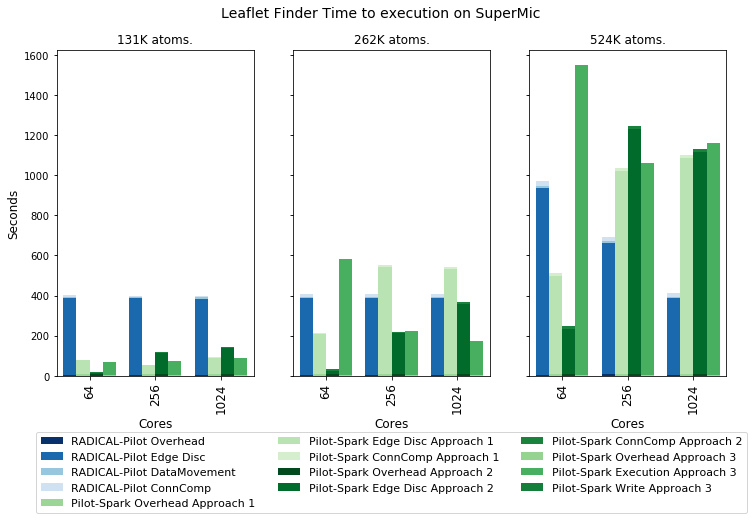

In [22]:
fig,axes = plt.subplots(nrows=1,ncols=3,sharey=True)
fig.set_size_inches(12,6)
RPmeansS[0:3].plot(kind='bar',x='Cores',ax=axes[0],stacked=True,position=2,width=0.20,colors=[blues(500),blues(200),blues(100),blues(50)],legend=False)
(SpSupBroad131mean.drop('Pilot-Spark TotalTime Approach 1',1)).plot(kind='bar',x='Cores',ax=axes[0],stacked=True,position=1,width=0.20,colors=[greens(100),greens(75),greens(50)],legend=False)
(SpSupColl131mean.drop('Pilot-Spark TotalTime Approach 2',1)).plot(kind='bar',x='Cores',ax=axes[0],stacked=True,position=0,width=0.20,colors=[greens(250),greens(225),greens(200)],legend=False)
(SpSupPcc131mean.drop('Pilot-Spark TotalTime Approach 3',1)).plot(kind='bar',x='Cores',ax=axes[0],stacked=True,position=-1,width=0.20,colors=[oranges(150),oranges(100),oranges(50)],legend=False)
axes[0].set_xlim(-.5,2.5)
axes[0].set_xticklabels(['64','256','1024'], fontsize=12)
axes[0].set_xlabel(axes[0].get_xlabel(),fontsize=12)
axes[0].set_ylabel('Seconds', fontsize=12)
axes[0].set_title('131K atoms.', fontsize=12)
#plt.savefig('SuperMicLeafLetFinder131K.png',dpi=800,bbox_inches='tight')

#fig,axes = plt.subplots(nrows=1,ncols=1)
#fig.set_size_inches(8,4)
RPmeansS[3:6].plot(kind='bar',x='Cores',ax=axes[1],stacked=True,position=2,width=0.20,colors=[blues(500),blues(200),blues(100),blues(50)],legend=True)
(SpSupBroad262mean.drop('Pilot-Spark TotalTime Approach 1',1)).plot(kind='bar',x='Cores',ax=axes[1],stacked=True,position=1,width=0.20,colors=[greens(100),greens(75),greens(50)],legend=True)
(SpSupColl262mean.drop('Pilot-Spark TotalTime Approach 2',1)).plot(kind='bar',x='Cores',ax=axes[1],stacked=True,position=0,width=0.20,colors=[greens(250),greens(225),greens(200)],legend=True)
(SpSupPcc262mean.drop('Pilot-Spark TotalTime Approach 3',1)).plot(kind='bar',x='Cores',ax=axes[1],stacked=True,position=-1,width=0.20,colors=[oranges(150),oranges(100),oranges(50)],legend=True)
axes[1].set_xlim(-.5,2.5)
axes[1].set_xticklabels(['64','256','1024'], fontsize=12)
axes[1].set_xlabel(axes[1].get_xlabel(),fontsize=12)
axes[1].set_title('262K atoms.', fontsize=12)
#plt.savefig('SuperMicLeafLetFinder262K.png',dpi=800,bbox_inches='tight')

#fig,axes = plt.subplots(nrows=1,ncols=1)
#fig.set_size_inches(8,4)
RPmeansS[6:9].plot(kind='bar',x='Cores',ax=axes[2],stacked=True,position=2,width=0.20,colors=[blues(500),blues(200),blues(100),blues(50)],legend=False)
(SpSupBroad524mean.drop('Pilot-Spark TotalTime Approach 1',1)).plot(kind='bar',x='Cores',ax=axes[2],stacked=True,position=1,width=0.20,colors=[greens(100),greens(75),greens(50)],legend=False)
(SpSupColl524mean.drop('Pilot-Spark TotalTime Approach 2',1)).plot(kind='bar',x='Cores',ax=axes[2],stacked=True,position=0,width=0.20,colors=[greens(250),greens(225),greens(200)],legend=False)
(SpSupPcc524mean.drop('Pilot-Spark TotalTime Approach 3',1)).plot(kind='bar',x='Cores',ax=axes[2],stacked=True,position=-1,width=0.20,colors=[oranges(150),oranges(100),oranges(50)],legend=False)
axes[2].set_xlim(-.5,2.5)
axes[2].set_xticklabels(['64','256','1024'], fontsize=12)
axes[2].set_xlabel(axes[2].get_xlabel(),fontsize=12)
#axes[0].set_ylim([0,2200])
#axes[1].set_ylim([0,2200])
#axes[2].set_ylim([0,2200])
axes[2].set_title('524K atoms.', fontsize=12)
#axes[1].text(.45,1900, 'Medium size\ntrajectories', fontsize=12)
fig.suptitle('Leaflet Finder Time to execution on SuperMic', fontsize=14)
axes[1].legend(fontsize=11,bbox_to_anchor=(0., -.42, 1,0), loc='lower center',ncol=3, borderaxespad=0.)
#axes[2].text(.5,1900, 'Large size\ntrajectories', fontsize=12)
#fig.text(0.5, -0.25, 'Number of Tasks (Cores)', ha='center',fontsize=13)
#fig.text(0.0, 0.5, 'Time (secs)', va='center', rotation='vertical',fontsize=13)
plt.savefig('SuperMicLeafLetFinder.pdf',dpi=800,bbox_inches='tight')

In [ ]:
RPmeansW

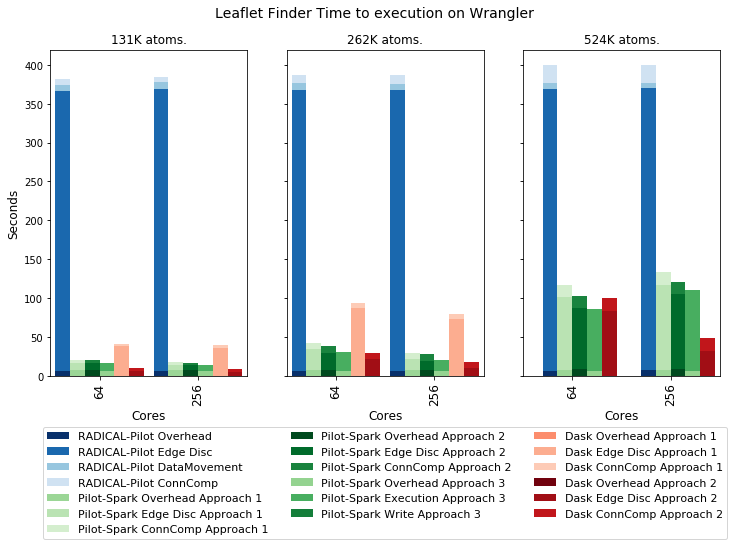

In [20]:
fig,axes = plt.subplots(nrows=1,ncols=3,sharey=True)
fig.set_size_inches(12,6)
RPmeansW[0:2].plot(kind='bar',x='Cores',ax=axes[0],stacked=True,position=3,width=0.15,colors=[blues(500),blues(200),blues(100),blues(50)],legend=False)
(SpWraBroad131mean.drop('Pilot-Spark TotalTime Approach 1',1))[0:2].plot(kind='bar',x='Cores',ax=axes[0],stacked=True,position=2,width=0.15,colors=[greens(100),greens(75),greens(50)],legend=False)
(SpWraColl131mean.drop('Pilot-Spark TotalTime Approach 2',1))[0:2].plot(kind='bar',x='Cores',ax=axes[0],stacked=True,position=1,width=0.15,colors=[greens(250),greens(225),greens(200)],legend=False)
(SpWraPcc131mean.drop('Pilot-Spark TotalTime Approach 3',1))[0:2].plot(kind='bar',x='Cores',ax=axes[0],stacked=True,position=0,width=0.15,colors=[oranges(150),oranges(100),oranges(50)],legend=False)
(DaWraBroad131mean.drop('Dask TotalTime Approach 1',1))[0:2].plot(kind='bar',x='Cores',ax=axes[0],stacked=True,position=-1,width=0.15,colors=[reds(100),reds(75),reds(50)],legend=False)
(DaWraColl131mean.drop('Dask TotalTime Approach 2',1))[0:2].plot(kind='bar',x='Cores',ax=axes[0],stacked=True,position=-2,width=0.15,colors=[reds(250),reds(225),reds(200)],legend=False)
axes[0].set_xlim(-.5,1.5)
axes[0].set_ylabel('Seconds', fontsize=12)
axes[0].set_xticklabels(['64','256'], fontsize=12)
axes[0].set_xlabel(axes[0].get_xlabel(),fontsize=12)
axes[0].set_title('131K atoms.', fontsize=12)
#plt.savefig('WranglerLeafLetFinder131K.png',dpi=800,bbox_inches='tight')

RPmeansW[2:4].plot(kind='bar',x='Cores',ax=axes[1],stacked=True,position=3,width=0.15,colors=[blues(500),blues(200),blues(100),blues(50)],legend=False)
(SpWraBroad262mean.drop('Pilot-Spark TotalTime Approach 1',1))[0:2].plot(kind='bar',x='Cores',ax=axes[1],stacked=True,position=2,width=0.15,colors=[greens(100),greens(75),greens(50)],legend=False)
(SpWraColl262mean.drop('Pilot-Spark TotalTime Approach 2',1))[0:2].plot(kind='bar',x='Cores',ax=axes[1],stacked=True,position=1,width=0.15,colors=[greens(250),greens(225),greens(200)],legend=False)
(SpWraPcc262mean.drop('Pilot-Spark TotalTime Approach 3',1))[0:2].plot(kind='bar',x='Cores',ax=axes[1],stacked=True,position=0,width=0.15,colors=[oranges(150),oranges(100),oranges(50)],legend=False)
(DaWraBroad262mean.drop('Dask TotalTime Approach 1',1))[0:2].plot(kind='bar',x='Cores',ax=axes[1],stacked=True,position=-1,width=0.15,colors=[reds(100),reds(75),reds(50)],legend=False)
(DaWraColl262mean.drop('Dask TotalTime Approach 2',1))[0:2].plot(kind='bar',x='Cores',ax=axes[1],stacked=True,position=-2,width=0.15,colors=[reds(250),reds(225),reds(200)],legend=False)
axes[1].set_xlim(-.5,1.5)
axes[1].set_xticklabels(['64','256'], fontsize=12)
axes[1].set_xlabel(axes[1].get_xlabel(),fontsize=12)
axes[1].set_title('262K atoms.', fontsize=12)
#plt.savefig('WranglerLeafLetFinder262K.png',dpi=800,bbox_inches='tight')

RPmeansW[4:6].plot(kind='bar',x='Cores',ax=axes[2],stacked=True,position=2,width=0.15,colors=[blues(500),blues(200),blues(100),blues(50)],legend=False)
(SpWraBroad524mean.drop('Pilot-Spark TotalTime Approach 1',1))[0:2].plot(kind='bar',x='Cores',ax=axes[2],stacked=True,position=1,width=0.15,colors=[greens(100),greens(75),greens(50)],legend=False)
(SpWraColl524mean.drop('Pilot-Spark TotalTime Approach 2',1))[0:2].plot(kind='bar',x='Cores',ax=axes[2],stacked=True,position=0,width=0.15,colors=[greens(250),greens(225),greens(200)],legend=False)
(SpWraPcc524mean.drop('Pilot-Spark TotalTime Approach 3',1))[0:2].plot(kind='bar',x='Cores',ax=axes[2],stacked=True,position=-1,width=0.15,colors=[oranges(150),oranges(100),oranges(50)],legend=False)
(DaWraColl524mean.drop('Dask TotalTime Approach 2',1))[0:2].plot(kind='bar',x='Cores',ax=axes[2],stacked=True,position=-2,width=0.15,colors=[reds(250),reds(225),reds(200)],legend=False)
axes[2].set_xlim(-.5,1.5)
#axes[0].set_ylim([0,2200])
#axes[1].set_ylim([0,2200])
#axes[2].set_ylim([0,2200])
axes[2].set_title('524K atoms.', fontsize=12)
axes[2].set_xticklabels(['64','256'], fontsize=12)
axes[2].set_xlabel(axes[2].get_xlabel(),fontsize=12)
#axes[1].text(.45,1900, 'Medium size\ntrajectories', fontsize=12)
fig.suptitle('Leaflet Finder Time to execution on Wrangler', fontsize=14)
axes[1].legend(fontsize=11,bbox_to_anchor=(0., -.50, 1,0), loc='lower center',ncol=3, borderaxespad=0.)
#axes[2].text(.5,1900, 'Large size\ntrajectories', fontsize=12)
#fig.text(0.5, -0.25, 'Number of Tasks (Cores)', ha='center',fontsize=13)
#fig.text(0.0, 0.5, 'Time (secs)', va='center', rotation='vertical',fontsize=13)
plt.savefig('WranglerLeafLetFinder.pdf',dpi=800,bbox_inches='tight')

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3)
rp_haus_short_plot.plot(kind='bar',ax=axes[0],stacked=True,sharey=True,sharex=True,width=width,position=1,yerr=rp_haus_short_plot_std,grid=True,legend=False,color=[blues(1000),blues(100)])
sp_haus_short_plot.plot(kind='bar',ax=axes[0],stacked=True,sharey=True,sharex=True,width=width,position=0,yerr=sp_haus_short_plot_std,grid=True,legend=False,color=[greens(1000),greens(100)])
rp_haus_med_plot.plot(kind='bar',ax=axes[1],stacked=True,sharey=True,sharex=True,width=width,position=1,yerr=rp_haus_med_plot_std,grid=True,legend=True,color=[blues(1000),blues(100)])
sp_haus_med_plot.plot(kind='bar',ax=axes[1],stacked=True,sharey=True,sharex=True,width=width,position=0,yerr=sp_haus_med_plot_std,grid=True,legend=True,color=[greens(1000),greens(100)])
rp_haus_long_plot.plot(kind='bar',ax=axes[2],stacked=True,sharey=True,sharex=True,width=width,position=1,yerr=rp_haus_long_plot_std,grid=True,legend=False,color=[blues(1000),blues(100)])
sp_haus_long_plot.plot(kind='bar',ax=axes[2],stacked=True,sharey=True,sharex=True,width=width,position=0,yerr=sp_haus_long_plot_std,grid=True,legend=False,color=[greens(1000),greens(100)])
DaskDataframe[DaskDataframe['Size']=='Short'].plot(kind='bar',x='Cores',y='Dask Execution',ax=axes[0],stacked=True,sharey=True,sharex=True,width=width,position=2,grid=True,legend=False,color=[reds(1000)])
DaskDataframe[DaskDataframe['Size']=='Med'].plot(kind='bar',x='Cores',y='Dask Execution',ax=axes[1],stacked=True,sharey=True,sharex=True,width=width,position=2,grid=True,legend=False,color=[reds(1000)])
DaskDataframe[DaskDataframe['Size']=='Long'].plot(kind='bar',x='Cores',y='Dask Execution',ax=axes[2],stacked=True,sharey=True,sharex=True,width=width,position=2,grid=True,legend=False,color=[reds(1000)])
axes[0].set_ylim([0,2200])
axes[1].set_ylim([0,2200])
axes[2].set_ylim([0,2200])
axes[0].text(.5,1900, 'Small size\ntrajectories', fontsize=12)
axes[1].text(.45,1900, 'Medium size\ntrajectories', fontsize=12)
axes[1].legend(fontsize=11,bbox_to_anchor=(0., -0.4, 1., .102), loc='lower center',ncol=2, borderaxespad=0.)
axes[2].text(.5,1900, 'Large size\ntrajectories', fontsize=12)
fig.text(0.5, -0.25, 'Number of Tasks (Cores)', ha='center',fontsize=13)
fig.text(0.0, 0.5, 'Time (secs)', va='center', rotation='vertical',fontsize=13)

In [ ]:
timings_64_1 = np.load('Spark/AppData/spBroad_lf/spBroad_lf_2048_64_1/unit.000000/timings.npz.npy')
timings_64_2 = np.load('Spark/AppData/spBroad_lf/spBroad_lf_2048_64_2/unit.000000/timings.npz.npy')
timings_64_3 = np.load('Spark/AppData/spBroad_lf/spBroad_lf_2048_64_3/unit.000000/timings.npz.npy')
timings_256_1 = np.load('Spark/AppData/spBroad_lf/spBroad_lf_512_256_1/unit.000000/timings.npz.npy')
timings_256_2 = np.load('Spark/AppData/spBroad_lf/spBroad_lf_512_256_2/unit.000000/timings.npz.npy')
timings_256_3 = np.load('Spark/AppData/spBroad_lf/spBroad_lf_512_256_3/unit.000000/timings.npz.npy')
timings_1024_1 = np.load('Spark/AppData/spBroad_lf/spBroad_lf_128_1024_1/unit.000000/timings.npz.npy')
timings_1024_2 = np.load('Spark/AppData/spBroad_lf/spBroad_lf_128_1024_2/unit.000000/timings.npz.npy')
timings_1024_3 = np.load('Spark/AppData/spBroad_lf/spBroad_lf_128_1024_3/unit.000000/timings.npz.npy')

In [ ]:
meanlineprops = dict(linestyle='--')
plt.figure()
upperLabels=['64 cores','64 cores','64 cores',
             '256 cores','256 cores','256 cores',\
             '1024 cores','1024 cores','1024 cores']
plt.boxplot([spBroad_app_64_1['Runtime']/1000,\
             spBroad_app_64_2['Runtime']/1000,\
             spBroad_app_64_3['Runtime']/1000,\
             spBroad_app_256_1['Runtime']/1000,\
             spBroad_app_256_2['Runtime']/1000,\
             spBroad_app_256_3['Runtime']/1000,\
             spBroad_app_1024_1['Runtime']/1000,\
             spBroad_app_1024_2['Runtime']/1000,\
             spBroad_app_1024_3['Runtime']/1000], 
            meanline=True, showmeans=True, showcaps=True, 
            showbox=True, showfliers=True, labels=upperLabels,meanprops=meanlineprops)
plt.xlabel('Experiment')
plt.ylabel('Time (s)')
plt.title('Executor Runtime vs Number of Cores/Tasks. Broadcast')
plt.xticks(rotation=45)
plt.savefig('ExecutorRuntime_broadcast.png',dpi=800,bbox_inches='tight')
plt.savefig('ExecutorRuntime_broadcast.pdf',dpi=800,bbox_inches='tight')

plt.figure()
plt.boxplot([timings_64_1[:,1]-timings_64_1[:,0],\
             timings_64_2[:,1]-timings_64_2[:,0],\
             timings_64_3[:,1]-timings_64_3[:,0],\
             timings_256_1[:,1]-timings_256_1[:,0],\
             timings_256_2[:,1]-timings_256_2[:,0],\
             timings_256_3[:,1]-timings_256_3[:,0],\
             timings_1024_1[:,1]-timings_1024_1[:,0],\
             timings_1024_2[:,1]-timings_1024_2[:,0],\
             timings_1024_3[:,1]-timings_1024_3[:,0]], 
            meanline=True, showmeans=True, showcaps=True, 
            showbox=True, showfliers=True, labels=upperLabels,meanprops=meanlineprops)
plt.xlabel('Experiment')
plt.ylabel('Time (s)')
plt.title('Map Function Runtime vs Number of Cores/Tasks. Broadcast')
plt.xticks(rotation=45)
plt.savefig('MapFunctionRuntime_broadcast.png',dpi=800,bbox_inches='tight')
plt.savefig('MapFunctionRuntime_broadcast.pdf',dpi=800,bbox_inches='tight')


plt.figure()
upperLabels=['64 cores','64 cores','64 cores',
             '256 cores','256 cores','256 cores',\
             '1024 cores','1024 cores','1024 cores']
plt.boxplot([spsc_lf_app_64_1['Runtime'],\
             spsc_lf_app_64_2['Runtime'],\
             spsc_lf_app_64_3['Runtime'],\
             spsc_lf_app_256_1['Runtime'],\
             spsc_lf_app_256_2['Runtime'],\
             spsc_lf_app_256_3['Runtime'],\
             spsc_lf_app_1024_1['Runtime'],\
             spsc_lf_app_1024_2['Runtime'],\
             spsc_lf_app_1024_3['Runtime']], 
            meanline=True, showmeans=True, showcaps=True, 
            showbox=True, showfliers=True, labels=upperLabels,meanprops=meanlineprops)
plt.xlabel('Experiment')
plt.ylabel('Time (ms)')
plt.title('Executor Runtime vs Number of Cores/Tasks. RDD')
plt.xticks(rotation=45)
plt.savefig('ExecutorRuntime_rdd.png',dpi=800,bbox_inches='tight')
plt.savefig('ExecutorRuntime_rdd.pdf',dpi=800,bbox_inches='tight')

plt.figure()
upperLabels=['64 cores','64 cores','64 cores',
             '256 cores','256 cores','256 cores',\
             '1024 cores','1024 cores','1024 cores']
plt.boxplot([spParCC_lf_ParCC_app_64_1['Runtime'],\
             spParCC_lf_ParCC_app_64_2['Runtime'],\
             spParCC_lf_ParCC_app_64_3['Runtime'],\
             spParCC_lf_ParCC_app_256_1['Runtime'],\
             spParCC_lf_ParCC_app_256_2['Runtime'],\
             spParCC_lf_ParCC_app_256_3['Runtime'],\
             spParCC_lf_ParCC_app_1024_1['Runtime'],\
             spParCC_lf_ParCC_app_1024_2['Runtime'],\
             spParCC_lf_ParCC_app_1024_3['Runtime']], 
            meanline=True, showmeans=True, showcaps=True, 
            showbox=True, showfliers=True, labels=upperLabels,meanprops=meanlineprops)
plt.xlabel('Experiment')
plt.ylabel('Time (ms)')
plt.title('Executor Runtime vs Number of Cores/Tasks. Parallel CC')
plt.xticks(rotation=45)
plt.savefig('ExecutorRuntime_parallelcc.png',dpi=800,bbox_inches='tight')
plt.savefig('ExecutorRuntime_parallelcc.pdf',dpi=800,bbox_inches='tight')

In [ ]:
meanlineprops = dict(linestyle='--')
plt.figure()
upperLabels=['64 cores','64 cores','64 cores',
             '256 cores','256 cores','256 cores',\
             '1024 cores','1024 cores','1024 cores']
plt.boxplot([spBroad_app_64_1['ResultSize'],\
             spBroad_app_64_2['ResultSize'],\
             spBroad_app_64_3['ResultSize'],\
             spBroad_app_256_1['ResultSize'],\
             spBroad_app_256_2['ResultSize'],\
             spBroad_app_256_3['ResultSize'],\
             spBroad_app_1024_1['ResultSize'],\
             spBroad_app_1024_2['ResultSize'],\
             spBroad_app_1024_3['ResultSize']], 
            meanline=True, showmeans=True, showcaps=True, 
            showbox=True, showfliers=True, labels=upperLabels)
plt.xlabel('Experiment')
plt.ylabel('Bytes')
plt.xticks(rotation=45)

plt.figure()
upperLabels=['64 cores','64 cores','64 cores',
             '256 cores','256 cores','256 cores',\
             '1024 cores','1024 cores','1024 cores']
plt.boxplot([spsc_lf_app_64_1['ResultSize'],\
             spsc_lf_app_64_2['ResultSize'],\
             spsc_lf_app_64_3['ResultSize'],\
             spsc_lf_app_256_1['ResultSize'],\
             spsc_lf_app_256_2['ResultSize'],\
             spsc_lf_app_256_3['ResultSize'],\
             spsc_lf_app_1024_1['ResultSize'],\
             spsc_lf_app_1024_2['ResultSize'],\
             spsc_lf_app_1024_3['ResultSize']], 
            meanline=True, showmeans=True, showcaps=True, 
            showbox=True, showfliers=True, labels=upperLabels)
plt.xlabel('Experiment')
plt.ylabel('Bytes')
plt.xticks(rotation=45)

plt.figure()
upperLabels=['64 cores','64 cores','64 cores',
             '256 cores','256 cores','256 cores',\
             '1024 cores','1024 cores','1024 cores']
plt.boxplot([spParCC_lf_ParCC_app_64_1['ResultSize'],\
             spParCC_lf_ParCC_app_64_2['ResultSize'],\
             spParCC_lf_ParCC_app_64_3['ResultSize'],\
             spParCC_lf_ParCC_app_256_1['ResultSize'],\
             spParCC_lf_ParCC_app_256_2['ResultSize'],\
             spParCC_lf_ParCC_app_256_3['ResultSize'],\
             spParCC_lf_ParCC_app_1024_1['ResultSize'],\
             spParCC_lf_ParCC_app_1024_2['ResultSize'],\
             spParCC_lf_ParCC_app_1024_3['ResultSize']], 
            meanline=True, showmeans=True, showcaps=True, 
            showbox=True, showfliers=True, labels=upperLabels)
plt.xlabel('Experiment')
plt.ylabel('Bytes')
plt.xticks(rotation=45)